In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import PIL
import os
import gradio as gr
import zipfile as z
import filesplit

# Data Dependencies

In [4]:
# Load Image Arrays and Corresponding Labels
pp = "../data/"
with open(pp+'image-arrays.npy', 'rb') as f:
    X = np.load(f)
with open(pp+'labels.npy', 'rb') as f:
    y = np.load(f)

In [3]:
print("X.shape", X.shape)
print("y.shape", y.shape)

X.shape (15501, 299, 299, 3)
y.shape (15501,)


In [16]:
pp = "../data/"
meta_data = pd.read_csv(pp+'herb22meta_data.csv').drop(labels="Unnamed: 0", axis=1)
meta_data

,id,category,path,scientific_name,family,genus,species,parent_folder,child_folder
0,00000__001,0,000/00/00000__001.jpg,Abies amabilis (Douglas ex Loudon) J.Forbes,Pinaceae,Abies,amabilis,0,0
1,00001__001,1,000/01/00001__001.jpg,Abies balsamea (L.) Mill.,Pinaceae,Abies,balsamea,0,1
2,00002__001,2,000/02/00002__001.jpg,Abies bracteata (D.Don) Poit.,Pinaceae,Abies,bracteata,0,2
3,00003__001,3,000/03/00003__001.jpg,Abies concolor (Gordon & Glend.) Lindl. ex Hil...,Pinaceae,Abies,concolor,0,3
4,00004__001,4,000/04/00004__001.jpg,Abies fraseri (Pursh) Poir.,Pinaceae,Abies,fraseri,0,4
...,...,...,...,...,...,...,...,...,...
15496,15500__017,15500,155/00/15500__017.jpg,Zostera marina L.,Zosteraceae,Zostera,marina,155,0
15497,15501__001,15501,155/01/15501__001.jpg,Zuloagaea bulbosa (Kunth) Bess,Poaceae,Zuloagaea,bulbosa,155,1
15498,15502__011,15502,155/02/15502__011.jpg,Zygophyllum californicum (Benth.) Christenh. &...,Zygophyllaceae,Zygophyllum,californicum,155,2
15499,15503__011,15503,155/03/15503__011.jpg,Zygophyllum laeve (Standl.) Christenh. & Byng,Zygophyllaceae,Zygophyllum,laeve,155,3


# Mock Example

In [15]:
X[0].shape

(299, 299, 3)

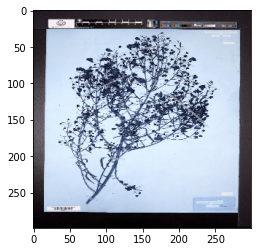

In [17]:
# Example Image:
image = X[234]
plt.imshow(image)
plt.show()

## Preprocess image

In [18]:
def prep_input_image(image, resize_factor=(380, 380)):
    image = image.astype('float32')
    # Normalize to ImageNet (the base model of the ResNet) 
    #image -= tf.constant([0.485, 0.456, 0.406], shape=[1, 1, 3], dtype=image.dtype)
    #image /= tf.constant([0.229, 0.224, 0.225], shape=[1, 1, 3], dtype=image.dtype)
    # Crop towards center of image (crop out borders)
    image = tf.image.central_crop(image, central_fraction = 0.9)
    # Resize
    image = np.array(image)
    image = cv2.resize(image, resize_factor, interpolation=cv2.INTER_LINEAR)
    # Rescale pixels
    image *= 1.0/255

    # Reshape dimensions
    image = image.reshape(1, image.shape[0], image.shape[1], 3)

    return image

image shape (1, 380, 380, 3)


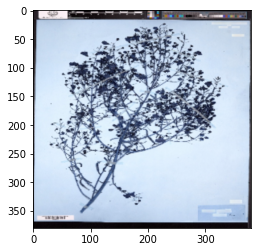

In [19]:
# Preprocess image
img_p = prep_input_image(image)
print("image shape", img_p.shape)
plt.imshow(img_p[0])
plt.show()

# Saving/Loading Model+Weights

In [25]:
# Create a split file of the model's weights
from filesplit.split import Split
split = Split('../data/herb-model_weights.h5', '../data/')
split.bysize(size=8e+7) # 50MB

In [26]:
# Merge split files back together to be used in model.load_weights
from filesplit.merge import Merge
merge = Merge('../data/', '../data/', 'full_weights.h5')
merge.merge(cleanup=False) ##keep split files with False

In [10]:
## Prep Model & Load-in Saved Weights
resize_resol = [380,380]
num_class = 15501
resnet = tf.keras.applications.resnet50.ResNet50(
       input_shape=(*resize_resol, 3),
       include_top=False,
       pooling="avg",
       weights="imagenet"
)   
model = tf.keras.Sequential([
       resnet,
       tf.keras.layers.Dropout(0.3),
       tf.keras.layers.Dense(1024, activation="relu"),
       tf.keras.layers.Dropout(0.3),
       tf.keras.layers.Dense(num_class, activation="softmax")
])
model.load_weights('../data/ResNet50_bn1024_OneCycle_CE-ls2e-1___weights.h5')
model.compile(optimizer='adam')



# SAVE MODEL ##run once
# model.save('../data/resnet-herbarium-model.h5') ##saves in too large of format
#model_json = model.to_json()
#model_weights = model.save_weights('../data/herb-model_weights.tf')
#with open('../data/herb-model.json', 'w') as f:
#    f.write(model_json)

# print( model.summary() )

https://www.webhostinghub.com/help/learn/website/managing-files/split-file
Split up weights file and then figure out how to load in back in and concatenate it with python code.

In [27]:
# Predict image
## Load in JSON model config
json_file = open('../data/herb-model.json', 'r')
loaded_json_mod = json_file.read()
json_file.close()
## Feed in JSON config to keras model
model = tf.keras.models.model_from_json(loaded_json_mod)
## Load saved weights into model
model.load_weights('../data/full_weights.h5')

## Make prediction
prediction = model.predict(img_p)
print(prediction.shape)
print(prediction)

1/1 [==============================] - 1s 826ms/step
(1, 15501)
[[2.3358478e-05 1.0398748e-05 1.6875510e-05 ... 1.8112240e-05
  5.5742046e-05 4.9060982e-05]]


In [11]:
# Create dictionary maps to correct for differences in meta_data and model trained data
map_name_to_cat_id = dict(zip(meta_data.scientific_name, meta_data.category))
map_label_to_name = dict(zip(range(15501), sorted(set(meta_data.scientific_name))))

In [26]:
y_pred = prediction
# Top 5 class prediction
num_class = 15501
top5pred = y_pred.reshape(num_class)
top5pred_idx = np.argpartition(top5pred, -5)[-5: ]

# Reverse the label encodings to get true category labels
top5pred_class = [map_name_to_cat_id[map_label_to_name[pred]] for pred in top5pred_idx]



# Probabilities for top 5 preds
top5pred_prob = y_pred.reshape(num_class)[top5pred_idx]

# Top class index
top_class = np.argmax(y_pred, axis=1)

print("Top 5 Predicted Class Index:", top5pred_idx)
print("Top 5 Predicted Class Number:", top5pred_class)
print("Top 5 Probabilities:", top5pred_prob)
print("top class idx", top_class)
print("top class", top5pred_class[np.where(top5pred_idx == top_class[0])[0][0]])

Top 5 Predicted Class Index: [ 8284 14097  1705  9942  1692]
Top 5 Predicted Class Number: [8287, 14101, 1706, 9946, 1693]
Top 5 Probabilities: [0.01294559 0.01349892 0.02112306 0.02015859 0.01696614]
top class idx [1705]
top class 1706


In [34]:
image_guess = pd.DataFrame({
    'class' : top5pred_class,
    'prob' : top5pred_prob
})
image_guess.sort_values(by = 'prob', ascending=False)

,class,prob
2,1706,0.021123
3,9946,0.020159
4,1693,0.016966
1,14101,0.013499
0,8287,0.012946


# Predict & Query Info
## Functional

In [13]:
model = tf.keras.models.load_model('../data/resnet-herbarium-model.h5')
prediction = model.predict(img_p)
print(prediction.shape)
print(prediction)

1/1 [==============================] - 2s 2s/step
(1, 15501)
[[2.3358478e-05 1.0398748e-05 1.6875510e-05 ... 1.8112240e-05
  5.5742046e-05 4.9060982e-05]]


In [56]:
def top_5_predictions(pred):
    # Create dictionary maps to correct for differences in meta_data and model trained data
    map_name_to_cat_id = dict(zip(meta_data.scientific_name, meta_data.category))
    map_label_to_name = dict(zip(range(15501), sorted(set(meta_data.scientific_name))))
    # Top 5 class prediction
    num_class = pred.shape[1] #15501 for full
    pred = pred.reshape(num_class)
    pred_idx = np.argpartition(pred, -5)[-5: ]

    # Map to get true category labels
    pred_class = np.array([map_name_to_cat_id[map_label_to_name[pred]] for pred in pred_idx])
    # Probabilities for top 5 preds
    pred_prob = pred.reshape(num_class)[pred_idx]

    image_guess = pd.DataFrame({
    'class' : pred_class,
    'prob' : pred_prob
    }).sort_values(by = 'prob', ascending=False)
    sorted_classes = [c for c in image_guess['class']]

    return image_guess, sorted_classes



top5, pred_classes = top_5_predictions(prediction)
top5

,class,prob
2,1706,0.021123
3,9946,0.020159
4,1693,0.016966
1,14101,0.013499
0,8287,0.012946


In [262]:
# Load Example Image Arrays and Corresponding Labels
pp = "../data/"
with open(pp+'image-arrays.npy', 'rb') as f:
    X = np.load(f)
with open(pp+'labels.npy', 'rb') as f:
    y = np.load(f)

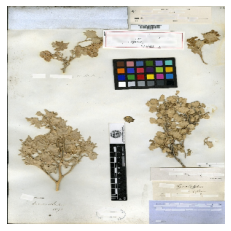

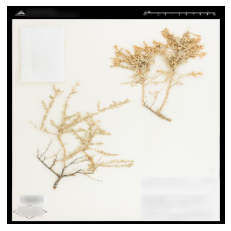

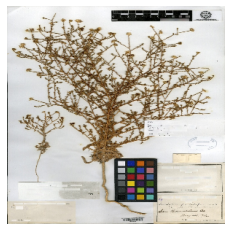

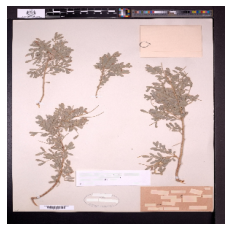

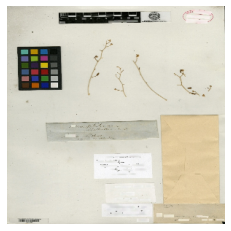

([1693, 1706, 8287, 9946, 14101],
 ['Atriplex hymenelytra (Torr.) S.Watson',
  'Atriplex polycarpa (Torr.) S.Watson',
  'Lessingia glandulifera A.Gray',
  'Olneya tesota A.Gray',
  'Stephanomeria exigua Nutt.'],
 ['Amaranthaceae', 'Amaranthaceae', 'Asteraceae', 'Fabaceae', 'Asteraceae'],
 ['Atriplex', 'Atriplex', 'Lessingia', 'Olneya', 'Stephanomeria'],
 ['hymenelytra', 'polycarpa', 'glandulifera', 'tesota', 'exigua'])

In [15]:
# Query the meta data for scientific name, family, genus, species, and example images
def query_plant_info(categories):
    
    # Locate row
    rows = meta_data.loc[meta_data.category.isin(categories)]
    # Extract info
    category = [c for c in rows['category']]
    scientific_name = [sc for sc in rows['scientific_name']]
    family = [f for f in rows['family']]
    genus = [g for g in rows['genus']]
    species = [s for s in rows['species']]
    images = []
    # plot example image
    for categ in [c for c in rows['category']]:
        img = X[np.where(y==categ)[0][0]]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    return category, scientific_name, family, genus, species#, img


query_plant_info(pred_classes)

# Gradio

https://gradio.app/image_classification_in_tensorflow/

In [20]:
def predict_image(image):
    
    # Preprocess
    ## Applies necessary preprocessing and reshapes to (1, 380, 380, 3)
    image = prep_input_image(image)

    # Predict using trained resnet model
    pred = model.predict(image)  

    # Create dictionary maps to correct for differences in meta_data and model trained data
    map_name_to_cat_id = dict(zip(meta_data.scientific_name, meta_data.category))
    map_label_to_name = dict(zip(range(15501), sorted(set(meta_data.scientific_name))))
    
    # Top 5 class prediction
    num_class = 15501
    pred = pred.reshape(num_class)

    # Map to get true category labels
    pred_labels = np.array([map_name_to_cat_id[map_label_to_name[idx]] for idx in range(0,num_class)])

    # Top 5 Index
    top5_idx = np.argpartition(pred, -5)[-5: ]

    return {pred_labels[i] : float(pred[i]) for i in top5_idx}

predict_image(cv2.imread('../example_images/ex_img_1000.jpg'))

1/1 [==============================] - 0s 287ms/step


{1505: 0.006744546815752983,
 1535: 0.007737625390291214,
 1190: 0.010496378876268864,
 3550: 0.007796048652380705,
 3878: 0.014050181955099106}

In [336]:
# Save some example images
#for i in [200, 499, 640, 850, 900, 1000]:
#    img = prep_input_image(X[i], resize_factor=(400, 400))
#    img = cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB)
#    plt.imsave(os.path.join("../example_images/ex_img_"+str(i)+".jpg"), img)

---
# Streamlit

In [99]:
meta_data[849:850]

,id,category,path,scientific_name,family,genus,species,parent_folder,child_folder
849,00850__001,850,008/50/00850__001.jpg,Anthurium michelii Guillaumin,Araceae,Anthurium,michelii,8,50


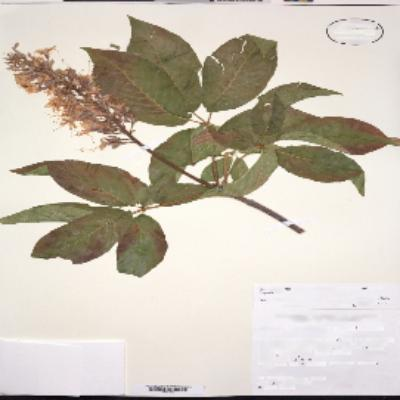

In [100]:
ip = "C:/Users/hanse/Documents/herbarium22/example_images/"
paths = [ip+'ex_img_200.jpg', ip+'ex_img_499.jpg', ip+'ex_img_640.jpg']
ex_imgs = [Image.open(paths[0]), Image.open(paths[1]), Image.open(paths[2])]
ex_imgs[0]

In [25]:
import streamlit as st
from PIL import Image, ImageOps

In [26]:
@st.cache(allow_output_mutation=True)
def load_model():
  model = tf.keras.models.load_model('../data/resnet-herbarium-model.h5')
  return model

with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Image Classification
         """
         )

file = st.file_uploader("Upload the image to be classified U0001F447", type=["jpg", "png"])
st.set_option('deprecation.showfileUploaderEncoding', False)

def upload_predict(upload_image, model):
        size = (380,380)    
#        image = ImageOps.fit(upload_image, size, Image.ANTIALIAS)
#        image = np.asarray(image)
        image = prep_input_image(image)
        prediction = model.predict(image)
        top5, pred_classes = top_5_predictions(prediction)
        return pred_classes

if file is None:
  st.text("Please upload an image file")
else:
  image = cv2.imread(file)
  st.image(image, use_column_width=True)
  pred_classes = upload_predict(image, model)
  st.write(pred_classes)



InternalHashError: module '__main__' has no attribute '__file__'

While caching the body of `load_model()`, Streamlit encountered an
object of type `builtins.function`, which it does not know how to hash.

**In this specific case, it's very likely you found a Streamlit bug so please
[file a bug report here.]
(https://github.com/streamlit/streamlit/issues/new/choose)**

In the meantime, you can try bypassing this error by registering a custom
hash function via the `hash_funcs` keyword in @st.cache(). For example:

```
@st.cache(hash_funcs={builtins.function: my_hash_func})
def my_func(...):
    ...
```

If you don't know where the object of type `builtins.function` is coming
from, try looking at the hash chain below for an object that you do recognize,
then pass that to `hash_funcs` instead:

```
Object of type builtins.function: <function load_model at 0x00000220A618F9A0>
```

Please see the `hash_funcs` [documentation]
(https://docs.streamlit.io/library/advanced-features/caching#the-hash_funcs-parameter)
for more details.
            

---
# Gradio

In [21]:
image = gr.inputs.Image(shape=(380,380))
label = gr.outputs.Label(num_top_classes=5)

examples = ["../example_images/ex_img_200.jpg", 
            "../example_images/ex_img_499.jpg", 
            "../example_images/ex_img_640.jpg"]

gr.Interface(fn=predict_image, inputs=image, outputs=label, examples=examples).launch(debug='True')

c:\Users\hanse\Documents\herbarium22\.venv\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Users\hanse\Documents\herbarium22\.venv\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 289ms/step


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\hanse\Documents\herbarium22\.venv\lib\site-packages\fastapi\encoders.py", line 137, in jsonable_encoder
    data = dict(obj)
TypeError: 'numpy.int32' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\hanse\Documents\herbarium22\.venv\lib\site-packages\fastapi\encoders.py", line 141, in jsonable_encoder
    data = vars(obj)
TypeError: vars() argument must have __dict__ attribute

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\hanse\Documents\herbarium22\.venv\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "c:\Users\hanse\Documents\herbarium22\.venv\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 78, in __call__
    return 

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x220a82a5150>, 'http://127.0.0.1:7860/', None)